# Ecuaciones Diferenciales Ordinarias

Una ecuación diferencial es una ecuación que expresa la relación entre una función y sus derivadas.

Cuando la función $f(x)$ depende únicamente de una variable $x \in \mathbb R$ definida en una dimensión, entonces la ecuación se dice **ordinaria**.

$$F\left(x, f(x), \frac{df(x)}{dx}, \frac{d^2f(x)}{dx^2}, \frac{d^3f(x)}{dx^3}, \ldots, \frac{d^{n-1}f(x)}{dx^{n-1}}\right) = \frac{d^{n}f(x)}{dx^{n}}$$

Donde $n$ es el orden de la EDO.

## EDO de primer orden

Por ejemplo, supongamos que contamos con la siguiente EDO:

$$\begin{aligned}
\frac{\mathrm{d}x}{\mathrm{d}t} &= (\alpha - \beta y(t))x(t), \
\frac{\mathrm{d}y}{\mathrm{d}t} &= (\delta x(t) - \gamma)y(t)
\end{aligned}$$

Donde $x$ es la presa e $y$ es la población de depredadores. 

In [1]:
# Define Lotka-Volterra model.
function lotka_volterra(du, u, p, t)
    # Model parameters.
    α, β, γ, δ = p
    # Current state.
    x, y = u

    # Evaluate differential equations.
    du[1] = (α - β * y) * x # prey
    du[2] = (δ * x - γ) * y # predator

    return nothing
end




lotka_volterra (generic function with 1 method)

In [2]:
using DifferentialEquations;

# Define initial-value problem.
u0 = [1.0, 1.0];
p = [1.5, 1.0, 3.0, 1.0];
tspan = (0.0, 10.0);
prob = ODEProblem(lotka_volterra, u0, tspan, p);


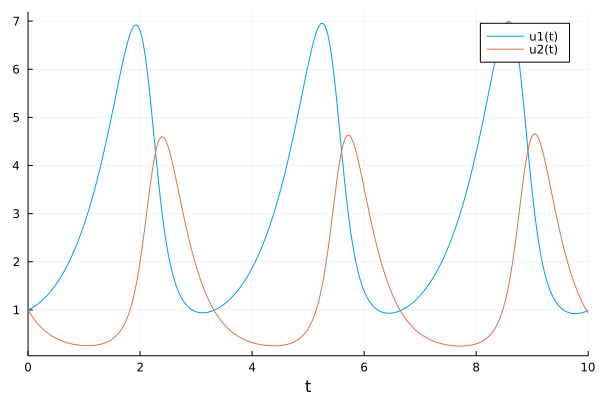

In [3]:
using Plots;

# Plot simulation.
plot(solve(prob, Euler(),dt=0.001))

Ahora, hacemos la estimación de los parámetros $\alpha, \beta, \gamma, \delta$ 

In [4]:
using Pkg
Pkg.add("XLSX");


    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.7/Project.toml`
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [5]:
using XLSX;
using DataFrames;

xf = XLSX.readxlsx("data/hare_lynx_data.xlsx")
m = xf[1][:]
data = DataFrame(m[3:end,1:3],:auto);

In [6]:
rename_dict = Dict(:x1 => :year, :x2 => :Hare, :x3 =>:Lynx)
rename!(data, rename_dict)

91×3 DataFrame
 Row │ year  Hare   Lynx  
     │ Any   Any    Any   
─────┼────────────────────
   1 │ 1845  19.58  30.09
   2 │ 1846  19.6   45.15
   3 │ 1847  19.61  49.15
   4 │ 1848  11.99  39.52
   5 │ 1849  28.04  21.23
   6 │ 1850  58     8.42
   7 │ 1851  74.6   5.56
   8 │ 1852  75.09  5.08
  ⋮  │  ⋮      ⋮      ⋮
  85 │ 1929  2.39   19.14
  86 │ 1930  4.23   6.98
  87 │ 1931  19.52  8.31
  88 │ 1932  82.11  16.01
  89 │ 1933  89.76  24.82
  90 │ 1934  81.66  29.7
  91 │ 1935  15.76  35.4
           76 rows omitted

In [7]:
data[!,:year]=convert.(Int,data[!,:year]);
data[!,:Hare]=convert.(Float64,data[!,:Hare]);
data[!,:Lynx]=convert.(Float64,data[!,:Lynx]);

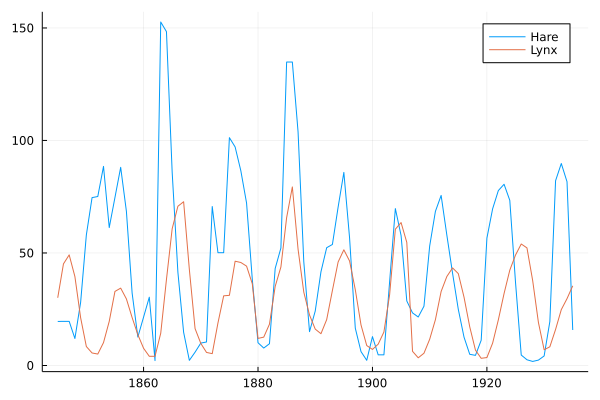

In [8]:
plot(data[!,:year],data[!,:Hare],label="Hare")
plot!(data[!,:year],data[!,:Lynx],label="Lynx")

In [12]:
u0=zeros(2)
t0,u0[1],u0[2]=data[1,:]
tspan=(data[1,:year],data[end,:year])
p = [1.5, 1.0, 3.0, 1.0];
prob = ODEProblem(lotka_volterra, u0, tspan, p);


In [39]:
sol = solve(prob,Euler(),dt=0.001,saveat=1);
rss=sum((Matrix(data[:,2:3])-reduce(hcat,sol.u)').^2)
print("Error Cuadratico Medio : ",rss)

Error Cuadratico Medio : 387735.71180837613

In [46]:
function ss2(x)
    prob = ODEProblem(lotka_volterra, u0, tspan,x);
    sol = solve(prob,Euler(),dt=0.001,saveat=1);
    rss=sum((Matrix(data[:,2:3])-reduce(hcat,sol.u)').^2)
end;

In [47]:
using Optim;

lower2 = p = [0.1, 0.1, 0.1, 0.1];
upper2 = p = [4.0, 4.0, 4.0, 4.0];
initial_x2 = [1.5, 1.0, 3.0, 1.0];

In [48]:
opt2_ss = Optim.optimize(ss2,lower2,upper2,initial_x2)

 * Status: success

 * Candidate solution
    Final objective value:     2.143954e+05

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.85e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   387  (vs limit Inf)
    Iterations:    10
    f(x) calls:    3561
    ∇f(x) calls:   3561


In [61]:
params=Optim.minimizer(opt2_ss);

4-element Vector{Float64}:
 1.8403245444019467
 0.10000000000000002
 2.585302415087884
 0.10000000000000002

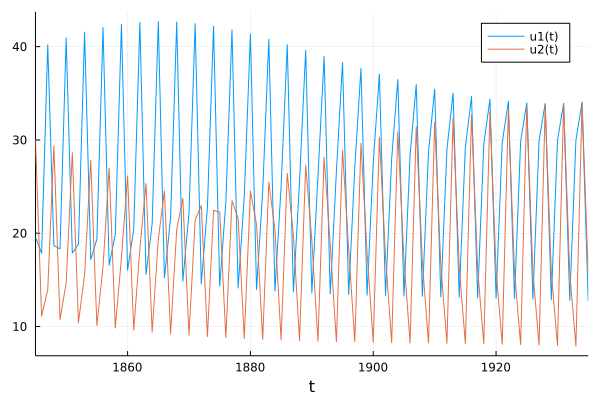

In [62]:
prob = ODEProblem(lotka_volterra, u0, tspan, params);
sol = solve(prob,Euler(),dt=0.001,saveat=1);
plot(sol)